<b>
An Evaluation of Different Machine Learning Algorithms for <br>
Predicting Academic Success Based on Given Data <br>
</b>
<br>
<b>
Mangawang, Felix <br>
Ong, Andrei <br>
Sillona, John <br>
Valero, Nigel <br>
</b>

<b> Introduction </b>

Alcohol consumption among students is a prevalent behavior and often serves as a coping mechanism for academic stress, heavy workloads, and social pressures. Some students turn to alcohol as a way to unwind after completing tasks, while others may use it to celebrate achievements or cope with failures. This recurring behavior raises concerns about how alcohol consumption may affect students’ academic performance.
To investigate this issue, researchers from the University of Minho in Portugal created a dataset that explores whether alcohol consumption influences the academic outcomes of secondary school students. The dataset was later published on the UCI Machine Learning Repository and is also available on Kaggle, a popular online platform for sharing datasets, conducting data analysis, and engaging in machine learning competitions.
Kaggle enables users to access a wide range of public datasets and collaborate with others through shared notebooks and discussions. The Student Alcohol Consumption dataset, in particular, has been widely used for exploring the relationships between student behavior, lifestyle choices, and academic performance.
While previous studies have often isolated specific behavioral traits like alcohol use, our research seeks to evaluate how machine learning algorithms perform when applied to a comprehensive dataset of student attributes. Rather than focusing solely on the effects of alcohol, this study reuses the dataset as a benchmarking platform for supervised classification algorithms. Our primary goal is to determine which machine learning models most accurately and reliably predict student performance, and to explore how feature combinations and preprocessing strategies affect these outcomes. 

<b> Required Libraries </b>

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif

<b>Dataset</b>

In [58]:
d1 = pd.read_csv("student-mat.csv", sep=",")
d2 = pd.read_csv("student-por.csv", sep=",")

merge_columns = ["school", "sex", "age", "address", "famsize", "Pstatus",
                 "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"]

d3 = pd.merge(d1, d2, on=merge_columns, suffixes=('_mat', '_por'))
print(len(d3))
print(d3)

382
    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
377     MS   F   18       U     LE3       T     3     1   teacher  services   
378     MS   F   18       U     GT3       T     1     1     other     other   
379     MS   F   18       U     GT3       T     1     1     other     other   
380     MS   M   17       U     LE3       T     3     1  services  services   
381     MS   M   18       R     LE3       T     3     2  services     other   

     ... famrel_por freetime_por  goout_por  Da

<b>Exploratory Analysis and Data Preprocessing</b>

The group first set the G3 and other features into a numbered and binary format from the previous range of number(for G3) and text value(yes/no). The dataframe was then checked for any NULL value. The data was then split into features and label and plots were 
included to show the distribution of grades, correlation between the features and passing, and the distribution of pass/fails among the features. Finally, the features were then scaled to ensure that there is minimal bias 

Dalc_mat         0
Walc_mat         0
absences_mat     0
studytime_mat    0
goout_mat        0
higher_mat       0
famsup_mat       0
romantic_mat     0
failures_mat     0
famrel_mat       0
schoolsup_mat    0
pass             0
dtype: int64


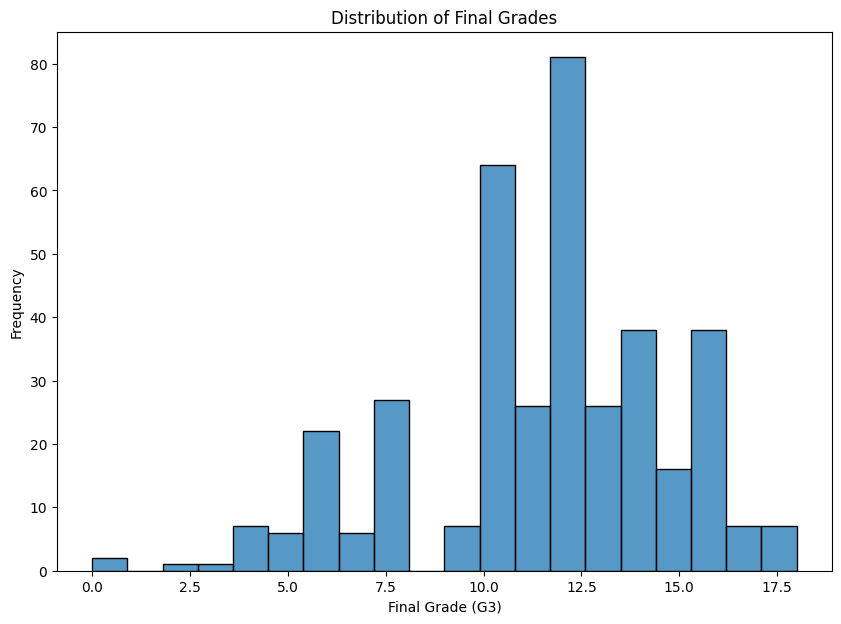

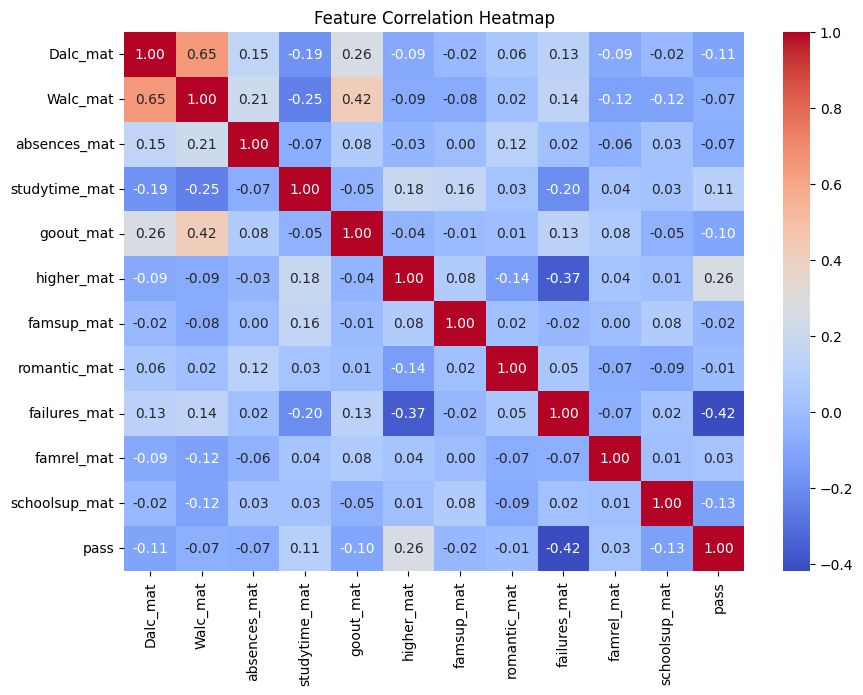

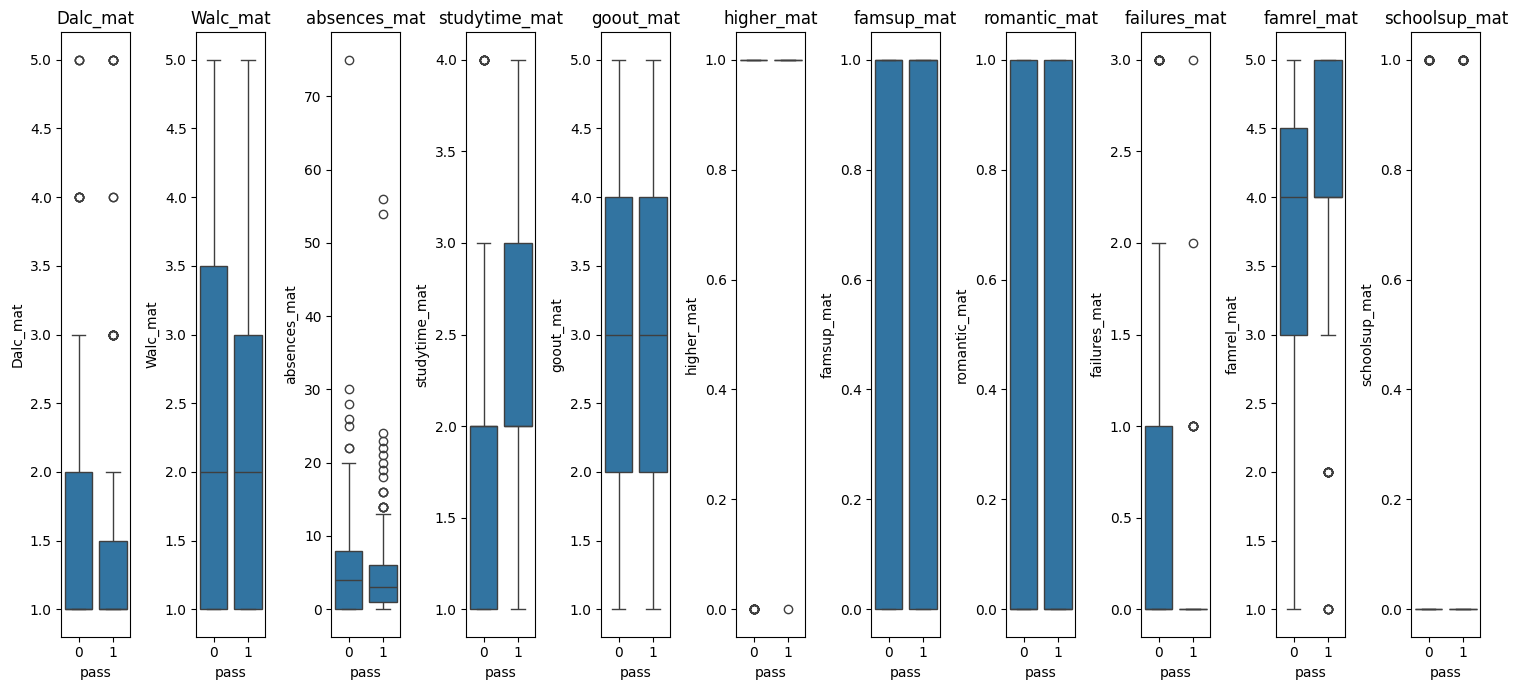

In [59]:
d3['G3'] = d3[['G3_mat', 'G3_por']].mean(axis=1).round()
d3['pass'] = d3['G3'].apply(lambda x: 1 if x >= 11 else 0)

features = ['Dalc_mat', 'Walc_mat', 'absences_mat', 'studytime_mat', 'goout_mat', 'higher_mat', 'famsup_mat', 'romantic_mat', 'failures_mat', 'famrel_mat', 'schoolsup_mat']
df = d3[features + ['pass']].copy()
df['higher_mat'] = df['higher_mat'].map({'yes': 1, 'no': 0})
df['famsup_mat'] = df['famsup_mat'].map({'yes': 1, 'no': 0})
df['romantic_mat'] = df['romantic_mat'].map({'yes': 1, 'no': 0})
df['schoolsup_mat'] = df['schoolsup_mat'].map({'yes': 1, 'no': 0})

print(df.isnull().sum())

X = df.drop('pass', axis=1)
y = df['pass']

# Exploratory Data Analysis
# Histogram of Final Grades
plt.figure(figsize=(10, 7))
sns.histplot(d3['G3'], bins=20)
plt.title("Distribution of Final Grades")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Frequency")
plt.show()

# Heatmap for correlation
plt.figure(figsize=(10, 7))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot of features by pass/fail
plt.figure(figsize=(15, 7))
for idx, col in enumerate(X.columns):
    plt.subplot(1, len(X.columns), idx + 1)
    sns.boxplot(x='pass', y=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<b>Model Training</b>
We have decided on the 3 algorithms: logistic regression, random forest, and support vector machine, to see how each would respond to our chosen data set. Logistic regression being a linear type model, random forest being an ensemble or "trees" type model, and support vector machine being a margin based model, would show how each algorithm would use the data to develop its model. 


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Hyperparameter Tuning using Random Search

some combinations arent valid for each solver so they were removed to reduce clutter

In [61]:
param_dist_lr = {
    'penalty':['l1','l2','elasticnet','none'],
    'C': np.logspace(-3, 3, 100),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'class_weight': ['balanced'],
    'max_iter'  : [100,1000,2500,5000]
}
random_search_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=1000),
    param_distributions=param_dist_lr,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_lr.fit(X_scaled, y)
best_params = random_search_lr.best_params_
print("Best Logistic Regression Parameters:", best_params)

results_df = pd.DataFrame(random_search_lr.cv_results_)
results_df = results_df[results_df['mean_test_score'].notna()] #remove this line

results_df = results_df[[
    'param_C', 'param_solver', 'param_class_weight',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]]
results_df = results_df.sort_values(by='param_C')


print("\nHyperparameter Combinations:")
print(results_df.to_string(index=False))


Best Logistic Regression Parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'class_weight': 'balanced', 'C': np.float64(0.40370172585965536)}

Hyperparameter Combinations:
  param_C param_solver param_class_weight  mean_test_score  std_test_score  rank_test_score
 0.002009    newton-cg           balanced         0.693746        0.037456                5
 0.403702         saga           balanced         0.748565        0.043946                1
 2.154435    newton-cg           balanced         0.740738        0.045385                2
 8.697490    newton-cg           balanced         0.740738        0.045385                2
53.366992        lbfgs           balanced         0.740738        0.050985                2


c:\Users\Hunte\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


75 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hunte\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Hunte\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Hunte\AppD

| param_C   | param_solver | param_class_weight | mean_test_score | std_test_score | rank_test_score |      |
|-----------|--------------|--------------------|-----------------|----------------|-----------------|------|
| 0.002009  | newton-cg    | balanced           | 0.693746        | 0.037456       | 5               |      |
| 0.403702  | saga         | balanced           | 0.748565        | 0.043946       | 1               | best |
| 2.154435  | newton-cg    | balanced           | 0.740738        | 0.045385       | 2               |      |
| 8.69749   | newton-cg    | balanced           | 0.740738        | 0.045385       | 2               |      |
| 53.366992 | lbfgs        | balanced           | 0.740738        | 0.050985       | 2               |      |

<b>Logistic Regression</b>


Logistic Regression


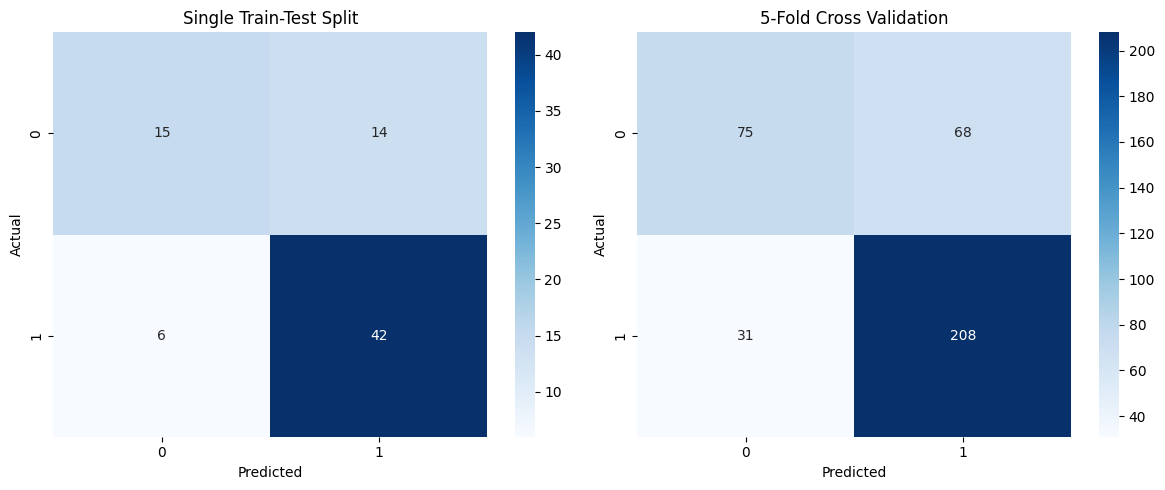

Singe Train-Test Split
              precision    recall  f1-score   support

           0     0.7143    0.5172    0.6000        29
           1     0.7500    0.8750    0.8077        48

    accuracy                         0.7403        77
   macro avg     0.7321    0.6961    0.7038        77
weighted avg     0.7365    0.7403    0.7295        77

5-Fold Cross Validation
              precision    recall  f1-score   support

           0     0.7075    0.5245    0.6024       143
           1     0.7536    0.8703    0.8078       239

    accuracy                         0.7408       382
   macro avg     0.7306    0.6974    0.7051       382
weighted avg     0.7364    0.7408    0.7309       382



In [62]:
print("\nLogistic Regression")
lr_model = LogisticRegression(**best_params)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

conf_mtrx1 = confusion_matrix(y_test, y_pred_lr)

# KFold cross validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(**best_params)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)


conf_mtrx2 = confusion_matrix(y_true_all, y_pred_all)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_mtrx1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Single Train-Test Split")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(conf_mtrx2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("5-Fold Cross Validation")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

#classification report for single and cross validation
print("Singe Train-Test Split")
print(classification_report(y_test, y_pred_lr, digits=4))
print("5-Fold Cross Validation")
print(classification_report(y_true_all, y_pred_all, digits=4))

Random Forest

Hyperparameter Tuning using Random Search

In [63]:
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [None, 5, 10, 20, 30], 
    'max_leaf_nodes': [None, 2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_scaled, y)

best_rf_params = random_search_rf.best_params_
print("Best Random Forest Parameters:", best_rf_params)

results_df = pd.DataFrame(random_search_rf.cv_results_)
results_df = results_df[[
    'param_n_estimators', 'param_max_depth', 'param_max_leaf_nodes', 'param_min_samples_split', 'param_min_samples_leaf', 'param_class_weight',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]]
results_df = results_df.sort_values(by='param_n_estimators')


print("\nHyperparameter Combinations:")
print(results_df.to_string(index=False))


Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 6, 'max_depth': None, 'class_weight': None}

Hyperparameter Combinations:
 param_n_estimators param_max_depth param_max_leaf_nodes  param_min_samples_split  param_min_samples_leaf param_class_weight  mean_test_score  std_test_score  rank_test_score
                100              10                 None                       10                       2           balanced         0.738278        0.049829               13
                100              30                    2                       10                       1           balanced         0.733049        0.020428               16
                100               5                    6                       10                       1           balanced         0.732946        0.027377               21
                100              10                 None                        2                       2  

| param_n_estimators | param_max_depth | param_max_leaf_nodes | param_min_samples_split | param_min_samples_leaf | param_class_weight | mean_test_score | std_test_score | rank_test_score |      |
|--------------------|-----------------|----------------------|-------------------------|------------------------|--------------------|-----------------|----------------|-----------------|------|
| 100                | 10              | None                 | 10                      | 2                      | balanced           | 0.738278        | 0.049829       | 13              |      |
| 100                | 30              | 2                    | 10                      | 1                      | balanced           | 0.733049        | 0.020428       | 16              |      |
| 100                | 5               | 6                    | 10                      | 1                      | balanced           | 0.732946        | 0.027377       | 21              |      |
| 100                | 10              | None                 | 2                       | 2                      | balanced           | 0.740772        | 0.04339        | 11              |      |
| 100                | 5               | 2                    | 5                       | 2                      | None               | 0.698975        | 0.021529       | 26              |      |
| 100                | 10              | None                 | 2                       | 1                      | None               | 0.748565        | 0.034354       | 10              |      |
| 100                | 20              | None                 | 5                       | 2                      | None               | 0.719891        | 0.031441       | 23              |      |
| 100                | 5               | 2                    | 2                       | 2                      | balanced           | 0.733049        | 0.020428       | 16              |      |
| 100                | 30              | 6                    | 2                       | 1                      | None               | 0.756528        | 0.013614       | 1               |      |
| 200                | None            | 4                    | 2                       | 2                      | balanced           | 0.733014        | 0.03929        | 18              |      |
| 200                | None            | 6                    | 10                      | 1                      | None               | 0.756528        | 0.013614       | 1               | best |
| 200                | 20              | 2                    | 5                       | 2                      | None               | 0.69108         | 0.033966       | 30              |      |
| 300                | None            | 4                    | 2                       | 2                      | balanced           | 0.738278        | 0.030575       | 12              |      |
| 300                | 10              | 2                    | 5                       | 1                      | None               | 0.698941        | 0.023578       | 29              |      |
| 500  | 30   | 6    | 5  | 1 | balanced | 0.73298  | 0.029459 | 19 |   |
| 500  | 10   | 4    | 5  | 2 | None     | 0.751333 | 0.013872 | 8  |   |
| 500  | 30   | 6    | 10 | 2 | None     | 0.75393  | 0.012724 | 5  |   |
| 500  | 10   | 6    | 10 | 2 | None     | 0.75393  | 0.012724 | 5  |   |
| 500  | 5    | 6    | 10 | 2 | balanced | 0.73298  | 0.019663 | 19 |   |
| 500  | 30   | 2    | 10 | 1 | None     | 0.706835 | 0.017195 | 24 |   |
| 500  | 20   | 4    | 2  | 1 | None     | 0.751333 | 0.013872 | 8  |   |
| 500  | None | 2    | 10 | 2 | None     | 0.706835 | 0.017195 | 24 |   |
| 1000 | 20   | 4    | 2  | 2 | None     | 0.756528 | 0.013614 | 1  |   |
| 1000 | 20   | None | 10 | 1 | balanced | 0.735578 | 0.035611 | 15 |   |
| 1000 | None | 2    | 2  | 2 | None     | 0.698975 | 0.018126 | 26 |   |
| 1000 | 10   | None | 5  | 1 | balanced | 0.732946 | 0.024609 | 21 |   |
| 1000 | None | 2    | 10 | 1 | None     | 0.698975 | 0.018126 | 26 |   |
| 1000 | None | None | 5  | 1 | balanced | 0.738175 | 0.025146 | 14 |   |
| 1000 | 10   | 6    | 10 | 1 | None     | 0.756528 | 0.013614 | 1  |   |
| 1000 | None | 6    | 2  | 2 | None     | 0.75393  | 0.012724 | 5  |   |

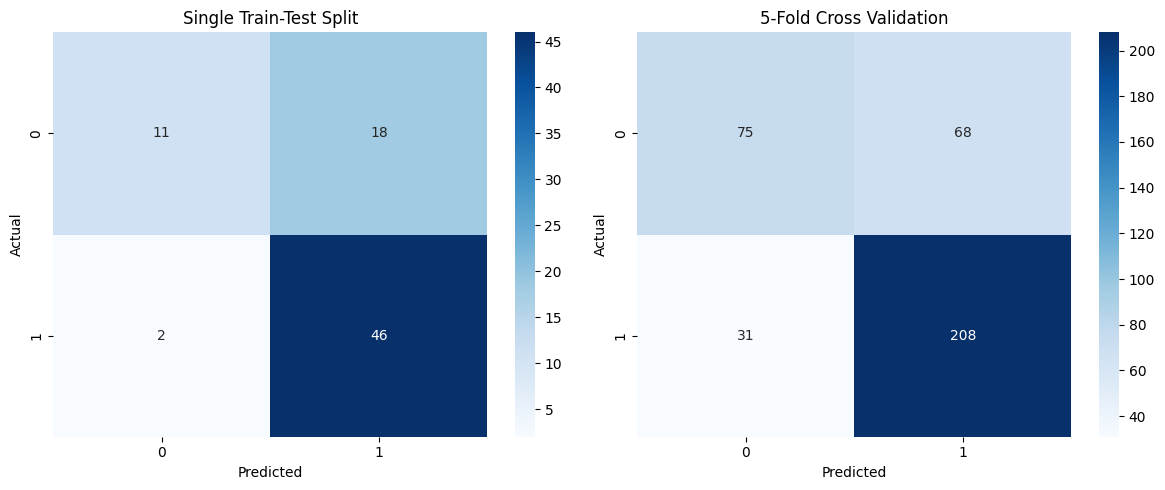

Singe Train-Test Split
              precision    recall  f1-score   support

           0     0.8462    0.3793    0.5238        29
           1     0.7188    0.9583    0.8214        48

    accuracy                         0.7403        77
   macro avg     0.7825    0.6688    0.6726        77
weighted avg     0.7667    0.7403    0.7093        77

5-Fold Cross Validation
              precision    recall  f1-score   support

           0     0.7075    0.5245    0.6024       143
           1     0.7536    0.8703    0.8078       239

    accuracy                         0.7408       382
   macro avg     0.7306    0.6974    0.7051       382
weighted avg     0.7364    0.7408    0.7309       382



In [64]:
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

conf_mtrx1 = confusion_matrix(y_test, y_pred_rf)

# KFold cross validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)


conf_mtrx2 = confusion_matrix(y_true_all, y_pred_all)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_mtrx1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Single Train-Test Split")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(conf_mtrx2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("5-Fold Cross Validation")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

#classification report for single and cross validation
print("Singe Train-Test Split")
print(classification_report(y_test, y_pred_rf, digits=4))
print("5-Fold Cross Validation")
print(classification_report(y_true_all, y_pred_all, digits=4))

Support Vector Machine (SVM)

Hyperparameter Tuning using Random Search

In [65]:
param_dist_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

random_search_svm = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_dist_svm,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_svm.fit(X_scaled, y)
best_svm_params = random_search_svm.best_params_
print("Best SVM Parameters:", best_svm_params)


results_df = pd.DataFrame(random_search_svm.cv_results_)
results_df = results_df[[
    'param_C', 'param_gamma', 'param_kernel', 'param_class_weight',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]]
results_df = results_df.sort_values(by='param_C')


print("\nHyperparameter Combinations:")
print(results_df.to_string(index=False))

Best SVM Parameters: {'kernel': 'rbf', 'gamma': 0.001, 'class_weight': 'balanced', 'C': 100}

Hyperparameter Combinations:
 param_C param_gamma param_kernel param_class_weight  mean_test_score  std_test_score  rank_test_score
     0.1       scale          rbf           balanced         0.685783        0.022979               10
     0.1        auto          rbf           balanced         0.685817        0.025382                9
     0.1       0.001          rbf           balanced         0.625666        0.005156               18
     0.1        0.01          rbf           balanced         0.680588        0.029778               12
     0.1      0.0001          rbf           balanced         0.625666        0.005156               18
     1.0       scale          rbf           balanced         0.724983        0.047822                5
     1.0      0.0001          rbf           balanced         0.520403        0.124106               20
     1.0       0.001          rbf           balanced 

| param_C | param_gamma | param_kernel | param_class_weight | mean_test_score | std_test_score | rank_test_score |   |
|---------|-------------|--------------|--------------------|-----------------|----------------|-----------------|---|
| 0.1     | scale       | rbf          | balanced           | 0.685783        | 0.022979       | 10              |   |
| 0.1     | auto        | rbf          | balanced           | 0.685817        | 0.025382       | 9               |   |
| 0.1     | 0.001       | rbf          | balanced           | 0.625666        | 0.005156       | 18              |   |
| 0.1     | 0.01        | rbf          | balanced           | 0.680588        | 0.029778       | 12              |   |
| 0.1     | 0.0001      | rbf          | balanced           | 0.625666        | 0.005156       | 18              |   |
| 1       | scale       | rbf          | balanced           | 0.724983        | 0.047822       | 5               |   |
| 1       | 0.0001      | rbf          | balanced           | 0.520403        | 0.124106       | 20              |   |
| 1       | 0.001       | rbf          | balanced           | 0.688448        | 0.019659       | 8               |   |
| 10      | 0.01        | rbf          | balanced           | 0.751128        | 0.037302       | 3               |   |
| 10      | auto        | rbf          | balanced           | 0.672727        | 0.031207       | 13              |   |
| 10      | 0.001       | rbf          | balanced           | 0.711825        | 0.045034       | 6               |   |
| 100     | auto        | rbf          | balanced           | 0.659638        | 0.043306       | 14              |   |
| 100     | scale       | rbf          | balanced           | 0.657006        | 0.046044       | 15              |   |
| 100     | 0.01        | rbf          | balanced           | 0.709296        | 0.025364       | 7               |   |
| 100  | 0.001  | rbf | balanced | 0.753759 | 0.037593 | 1  | best |
| 1000 | 0.001  | rbf | balanced | 0.751128 | 0.037302 | 3  |      |
| 1000 | scale  | rbf | balanced | 0.630998 | 0.041489 | 17 |      |
| 1000 | 0.01   | rbf | balanced | 0.683151 | 0.042488 | 11 |      |
| 1000 | auto   | rbf | balanced | 0.636227 | 0.042326 | 16 |      |
| 1000 | 0.0001 | rbf | balanced | 0.753759 | 0.037593 | 1  |      |

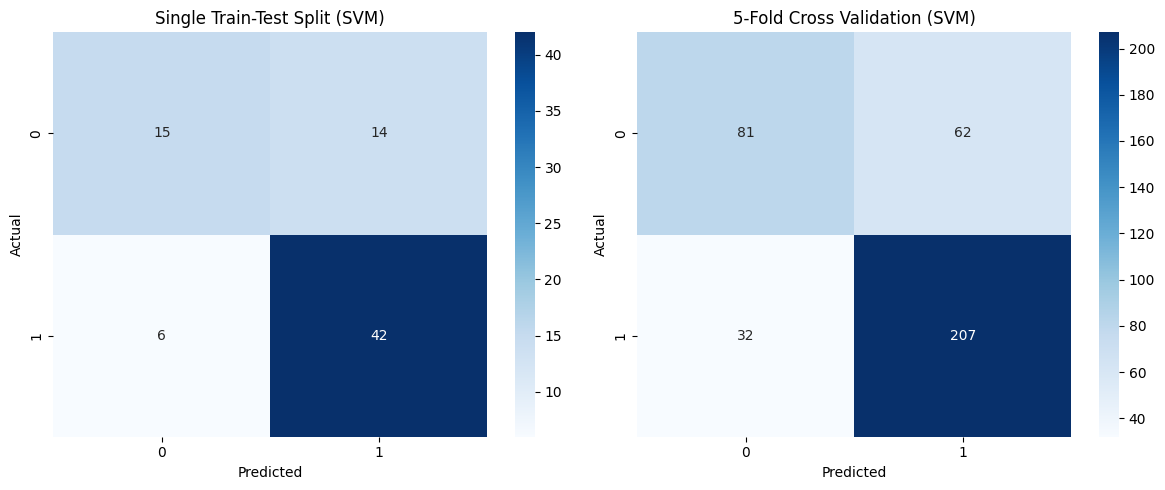

Single Train-Test Split (SVM)
              precision    recall  f1-score   support

           0     0.7143    0.5172    0.6000        29
           1     0.7500    0.8750    0.8077        48

    accuracy                         0.7403        77
   macro avg     0.7321    0.6961    0.7038        77
weighted avg     0.7365    0.7403    0.7295        77

5-Fold Cross Validation (SVM)
              precision    recall  f1-score   support

           0     0.7168    0.5664    0.6328       143
           1     0.7695    0.8661    0.8150       239

    accuracy                         0.7539       382
   macro avg     0.7432    0.7163    0.7239       382
weighted avg     0.7498    0.7539    0.7468       382



In [66]:
svm_model = SVC(**best_svm_params, probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

conf_mtrx1 = confusion_matrix(y_test, y_pred_svm)

# KFold cross validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model = SVC(**best_svm_params, probability=True, random_state=42)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)

conf_mtrx2 = confusion_matrix(y_true_all, y_pred_all)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_mtrx1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Single Train-Test Split (SVM)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(conf_mtrx2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("5-Fold Cross Validation (SVM)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

#classification report for single and cross validation
print("Single Train-Test Split (SVM)")
print(classification_report(y_test, y_pred_svm, digits=4))
print("5-Fold Cross Validation (SVM)")
print(classification_report(y_true_all, y_pred_all, digits=4))

<b>Analysis</b>


 ANOVA F-test
Dalc_mat: F=4.78, p=0.0293
Walc_mat: F=1.73, p=0.1892
absences_mat: F=1.98, p=0.1603
studytime_mat: F=4.49, p=0.0348
goout_mat: F=4.22, p=0.0406
higher_mat: F=28.00, p=0.0000
famsup_mat: F=0.17, p=0.6786
romantic_mat: F=0.03, p=0.8733
failures_mat: F=80.97, p=0.0000
famrel_mat: F=0.38, p=0.5371
schoolsup_mat: F=6.11, p=0.0139


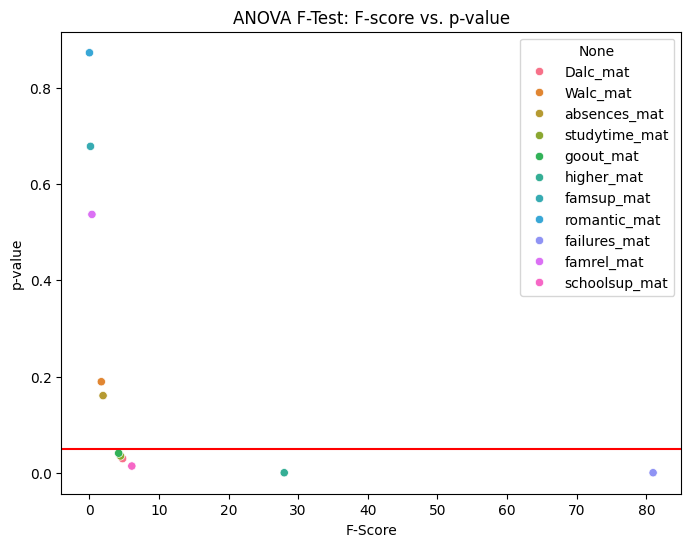

In [67]:
# Multivariate Analysis 
print("\n ANOVA F-test")
f_stat, p_val = f_classif(X, y)
for i, col in enumerate(X.columns):
    print(f"{col}: F={f_stat[i]:.2f}, p={p_val[i]:.4f}")

anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_stat,
    'p-value': p_val
})

plt.figure(figsize=(8, 6))
sns.scatterplot(x=f_stat, y=p_val, hue=X.columns)
plt.axhline(0.05, color='red', linestyle='-', label='p = 0.05')
plt.xlabel("F-Score")
plt.ylabel("p-value")
plt.title("ANOVA F-Test: F-score vs. p-value")
plt.show()

In [68]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_scaled, y)
print("\nLogistic Regression Coefficients:")
for feature, coef in zip(X.columns, lr.coef_[0]):
    print(f"{feature}: {coef:.4f}")
df_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
})
fig = px.bar(df_lr, x='Feature', y='Coefficient', title='Logistic Regression Coefficients', color='Coefficient')
fig.show()


Logistic Regression Coefficients:
Dalc_mat: -0.1490
Walc_mat: 0.1604
absences_mat: -0.0977
studytime_mat: 0.0337
goout_mat: -0.1519
higher_mat: 0.5763
famsup_mat: -0.0839
romantic_mat: 0.1017
failures_mat: -1.2048
famrel_mat: -0.0095
schoolsup_mat: -0.2703


In [69]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
importances_rf = rf.feature_importances_
print("Random Forest Feature Importances:")
for feature, importance in zip(X.columns, importances_rf):
    print(f"{feature}: {importance:.4f}")

df_rf = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': importances_rf
})
px.bar(df_rf, x='Feature', y='Importance', title='Random Forest Feature Importance').show()

Random Forest Feature Importances:
Dalc_mat: 0.0579
Walc_mat: 0.0979
absences_mat: 0.1879
studytime_mat: 0.0947
goout_mat: 0.1229
higher_mat: 0.0337
famsup_mat: 0.0450
romantic_mat: 0.0499
failures_mat: 0.1725
famrel_mat: 0.0948
schoolsup_mat: 0.0428


In [70]:
# SVM
clf_svm = LinearSVC()
clf_svm.fit(X_scaled, y)  # scale input for better performance
print("\nLinear SVM Coefficients:")
for feature, coef in zip(X.columns, clf_svm.coef_[0]):
    print(f"{feature}: {coef:.4f}")

# SVM Coefficients Bar Plot
df_svm = pd.DataFrame({
    'Feature': X.columns, 
    'Coefficient': clf_svm.coef_[0]
})
df_svm['AbsCoefficient'] = df_svm['Coefficient'].abs()
px.bar(df_svm, x='Feature', y='Coefficient', title='Linear SVM Coefficients').show()


Linear SVM Coefficients:
Dalc_mat: -0.0663
Walc_mat: 0.0716
absences_mat: -0.0425
studytime_mat: 0.0149
goout_mat: -0.0626
higher_mat: 0.2359
famsup_mat: -0.0354
romantic_mat: 0.0374
failures_mat: -0.4808
famrel_mat: -0.0030
schoolsup_mat: -0.1143
